In [16]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results

In [2]:
scores = []
with open('scores.pkl', 'rb') as f:
    scores = pickle.load(f)

In [3]:
column_names = "url;A;F;I;R;A1;F1;F2;F3;F4;I1;I2;I3;R1;R1.1;R1.2;R1.3;FAIR;FAIR%;FsF-F1-01D;FsF-F1-01D-1;FsF-F1-01D-2;FsF-F1-02D;FsF-F1-02D-1;FsF-F1-02D-2;FsF-F2-01M;FsF-F2-01M-1;FsF-F2-01M-2;FsF-F2-01M-3;FsF-F3-01M;FsF-F3-01M-1;FsF-F3-01M-2;FsF-F4-01M;FsF-F4-01M-1;FsF-F4-01M-2;FsF-A1-01M;FsF-A1-01M-1;FsF-A1-01M-3;FsF-A1-01M-2;FsF-A1-02M;FsF-A1-02M-1;FsF-A1-03D;FsF-A1-03D-1;FsF-I1-01M;FsF-I1-01M-1;FsF-I1-01M-2;FsF-I2-01M;FsF-I2-01M-1;FsF-I2-01M-2;FsF-I3-01M;FsF-I3-01M-1;FsF-I3-01M-2;FsF-R1-01MD;FsF-R1-01MD-1;FsF-R1-01MD-1a;FsF-R1-01MD-1b;FsF-R1-01MD-2;FsF-R1-01MD-2a;FsF-R1-01MD-2b;FsF-R1-01MD-2c;FsF-R1-01MD-3;FsF-R1-01MD-4;FsF-R1.1-01M;FsF-R1.1-01M-1;FsF-R1.1-01M-2;FsF-R1.2-01M;FsF-R1.2-01M-1;FsF-R1.2-01M-2;FsF-R1.3-01M;FsF-R1.3-01M-1;FsF-R1.3-01M-2;FsF-R1.3-01M-3;FsF-R1.3-02D;FsF-R1.3-02D-1;FsF-R1.3-02D-1a;FsF-R1.3-02D-1b;FsF-R1.3-02D-1c".split(";")

In [4]:
invenio_data = {}
enhanced_data = {}

for score in scores:
    invenio_row = []
    enhanced_row = []
    
    invenio_row.append(score['invenio_url'])
    enhanced_row.append(score['enhanced_url'])
    
    invenio_json = score['invenio_score']
    enhanced_json = score['enhanced_score']
    
    for k,v in invenio_json['summary']['score_earned'].items():
        invenio_row.append(v)
    for k,v in enhanced_json['summary']['score_earned'].items():
        enhanced_row.append(v)
        
    invenio_row.append(invenio_json['summary']['score_percent']['FAIR'])
    enhanced_row.append(enhanced_json['summary']['score_percent']['FAIR'])
        
    for metric in invenio_json['results']:
        invenio_row.append(metric['score']['earned'])
        for test, value in metric['metric_tests'].items():
            invenio_row.append(value['metric_test_score']['earned'])
            
    for metric in enhanced_json['results']:
        enhanced_row.append(metric['score']['earned'])
        for test, value in metric['metric_tests'].items():
            enhanced_row.append(value['metric_test_score']['earned'])
    
    invenio_data[score['record_id']] = invenio_row
    enhanced_data[score['record_id']] = enhanced_row

invenio_df = pd.DataFrame.from_dict(data=invenio_data, columns=column_names, orient='index')
enhanced_df = pd.DataFrame.from_dict(data=enhanced_data, columns=column_names, orient='index')


In [5]:
summary = {}
metrics = {}
tests = {}
for score in scores:
    invenio_json = score['invenio_score']
    for k,v in invenio_json['summary']['score_total'].items():
        summary[k] = v
        
    for metric in invenio_json['results']:
        metrics[metric['metric_identifier']] = metric['score']['total']
        for test, value in metric['metric_tests'].items():
            tests[test] = value['metric_test_score']['total']

In [6]:
# remove an outlier
invenio_df = invenio_df.drop(index="z8z7p-tgw13")
enhanced_df = enhanced_df.drop(index="z8z7p-tgw13")

In [18]:
def graph_stats_max(dataset1: pd.DataFrame, dataset2: pd.DataFrame, dataset1_title: str, dataset2_title: str,
                    stats: dict, title: str):
    keys = [key for key, _ in stats.items()]
    data = {key: [] for key in [dataset1_title, dataset2_title]}
    for key, v in stats.items():
        data[dataset1_title].append(dataset1[dataset1[key] == v][key].count())
        data[dataset2_title].append(dataset2[dataset2[key] == v][key].count())

    x = np.arange(len(keys))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in data.items():
        offset = width * multiplier * 1.5
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of records')
    ax.set_title(title)
    ax.set_xticks(x + width * 0.75, keys, rotation=45, rotation_mode="anchor", ha="right")
    ax.legend(loc='upper left', ncols=2)
    ax.set_ylim(0, 260)
    fig.set_size_inches(14, 5)
    # ax.tick_params("x", rotation=45, )

    plt.show()
    
def graph_stats_singular(dataset: pd.DataFrame, stats: dict,  title: str):
    #scale = set()
    #for key, _ in stats.items():
    #    for scale_element in dataset[key].unique():
    #        scale.add(scale_element)
    #scale = list(scale)
    #scale.sort()
    legend_desc = 'maximal number of points'
    
    keys = [key for key, _ in stats.items()]
    data = {key: [] for key in [legend_desc]} #scale}
    for key, v in stats.items():
       data[legend_desc].append(dataset[dataset[key] == v][key].count())
        #for scale_element in scale:
           # data[scale_element].append(dataset[dataset[key] == scale_element][key].count())
    
    x = np.arange(len(keys))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    fig, ax = plt.subplots(layout='constrained')
    
    for attribute, measurement in data.items():
        offset = width * multiplier * 1.5
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1
        
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of records')
    ax.set_title(title)
    ax.set_xticks(x, keys, rotation=45, rotation_mode="anchor", ha="right")
    # ax.legend(loc='upper left', ncols=2)
    ax.set_ylim(0, 240)
    fig.set_size_inches(14,5)
    # ax.tick_params("x", rotation=45, )
    
    plt.show()

-----

# Present statistical properties

In [7]:
invenio_df.describe()

,A,F,I,R,A1,F1,F2,F3,F4,I1,...,FsF-R1.2-01M-2,FsF-R1.3-01M,FsF-R1.3-01M-1,FsF-R1.3-01M-2,FsF-R1.3-01M-3,FsF-R1.3-02D,FsF-R1.3-02D-1,FsF-R1.3-02D-1a,FsF-R1.3-02D-1b,FsF-R1.3-02D-1c
count,210.0,210.000000,210.000000,210.000000,210.0,210.0,210.000000,210.0,210.0,210.0,...,210.0,210.0,210.0,210.0,210.0,210.000000,210.000000,210.0,210.0,210.0
mean,3.0,4.123810,3.004762,5.819048,3.0,1.0,1.123810,1.0,1.0,2.0,...,0.0,1.0,1.0,0.0,1.0,0.890476,0.890476,0.0,0.0,0.0
std,0.0,0.330151,0.069007,1.023933,0.0,0.0,0.330151,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.313042,0.313042,0.0,0.0,0.0
min,3.0,4.000000,3.000000,3.000000,3.0,1.0,1.000000,1.0,1.0,2.0,...,0.0,1.0,1.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0
25%,3.0,4.000000,3.000000,5.000000,3.0,1.0,1.000000,1.0,1.0,2.0,...,0.0,1.0,1.0,0.0,1.0,1.000000,1.000000,0.0,0.0,0.0
50%,3.0,4.000000,3.000000,6.000000,3.0,1.0,1.000000,1.0,1.0,2.0,...,0.0,1.0,1.0,0.0,1.0,1.000000,1.000000,0.0,0.0,0.0
75%,3.0,4.000000,3.000000,6.000000,3.0,1.0,1.000000,1.0,1.0,2.0,...,0.0,1.0,1.0,0.0,1.0,1.000000,1.000000,0.0,0.0,0.0
max,3.0,5.000000,4.000000,8.000000,3.0,1.0,2.000000,1.0,1.0,2.0,...,0.0,1.0,1.0,0.0,1.0,1.000000,1.000000,0.0,0.0,0.0


In [8]:
enhanced_df.describe()

,A,F,I,R,A1,F1,F2,F3,F4,I1,...,FsF-R1.2-01M-2,FsF-R1.3-01M,FsF-R1.3-01M-1,FsF-R1.3-01M-2,FsF-R1.3-01M-3,FsF-R1.3-02D,FsF-R1.3-02D-1,FsF-R1.3-02D-1a,FsF-R1.3-02D-1b,FsF-R1.3-02D-1c
count,210.0,210.000000,210.0,210.000000,210.0,210.0,210.000000,210.0,210.0,210.0,...,210.0,210.0,210.0,210.0,210.0,210.000000,210.000000,210.0,210.0,210.0
mean,3.0,4.123810,4.0,7.919048,3.0,1.0,1.123810,1.0,1.0,2.0,...,1.0,1.0,0.0,0.0,1.0,0.885714,0.885714,0.0,0.0,0.0
std,0.0,0.330151,0.0,1.193330,0.0,0.0,0.330151,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.318918,0.318918,0.0,0.0,0.0
min,3.0,4.000000,4.0,4.000000,3.0,1.0,1.000000,1.0,1.0,2.0,...,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0
25%,3.0,4.000000,4.0,7.000000,3.0,1.0,1.000000,1.0,1.0,2.0,...,1.0,1.0,0.0,0.0,1.0,1.000000,1.000000,0.0,0.0,0.0
50%,3.0,4.000000,4.0,8.000000,3.0,1.0,1.000000,1.0,1.0,2.0,...,1.0,1.0,0.0,0.0,1.0,1.000000,1.000000,0.0,0.0,0.0
75%,3.0,4.000000,4.0,9.000000,3.0,1.0,1.000000,1.0,1.0,2.0,...,1.0,1.0,0.0,0.0,1.0,1.000000,1.000000,0.0,0.0,0.0
max,3.0,5.000000,4.0,9.000000,3.0,1.0,2.000000,1.0,1.0,2.0,...,1.0,1.0,0.0,0.0,1.0,1.000000,1.000000,0.0,0.0,0.0


In [9]:
# the score is improved for every record
for record_in in invenio_df.index:
    if not invenio_df.loc[record_in]['FAIR%'] < enhanced_df.loc[record_in]['FAIR%']:
        print(record_in)

In [10]:
differences_data = {}
for record_id in invenio_df.index:
    differences_data[record_id] = [enhanced_df.loc[record_id]['FAIR%'] - invenio_df.loc[record_id]['FAIR%']]
    differences_data[record_id].append(invenio_df.loc[record_id]['FAIR%'])
    differences_data[record_id].append(enhanced_df.loc[record_id]['FAIR%'])
    differences_data[record_id].append(enhanced_df.loc[record_id]['FAIR'] - invenio_df.loc[record_id]['FAIR'])
    differences_data[record_id].append(invenio_df.loc[record_id]['FAIR'])
    differences_data[record_id].append(enhanced_df.loc[record_id]['FAIR'])
    
differences_df = pd.DataFrame.from_dict(data=differences_data, columns=['FAIR score difference', 'InvenioRDM score', 'Enhanced score', 'FAIR points score difference', 'InvenioRDM score points', 'Enhanced score points'], orient='index')

In [11]:
differences_df.describe()

,FAIR score difference,InvenioRDM score,Enhanced score,FAIR points score difference,InvenioRDM score points,Enhanced score points
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,12.895190,66.448476,79.343667,3.095238,15.947619,19.042857
std,3.286765,4.721921,5.533322,0.788965,1.133280,1.328045
min,8.330000,54.170000,62.500000,2.000000,13.000000,15.000000
25%,8.340000,62.500000,75.000000,2.000000,15.000000,18.000000
50%,12.500000,66.670000,83.330000,3.000000,16.000000,20.000000
75%,16.660000,70.830000,83.330000,4.000000,17.000000,20.000000
max,16.670000,75.000000,87.500000,4.000000,18.000000,21.000000


------

# Graphs used in the paper

<Axes: title={'center': 'Distribution of the FAIRness score'}, xlabel='FAIRness score [%]', ylabel='Number of records'>

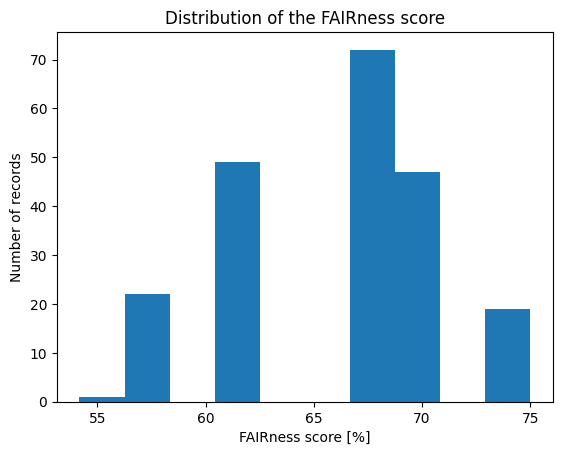

In [12]:
# FAIRness distribution
invenio_df['FAIR%'].plot.hist(ylabel="Number of records", xlabel="FAIRness score [%]", title="Distribution of the FAIRness score")

<Axes: title={'center': 'Distribution of the FAIRness score'}, xlabel='FAIRness score [%]', ylabel='Number of records'>

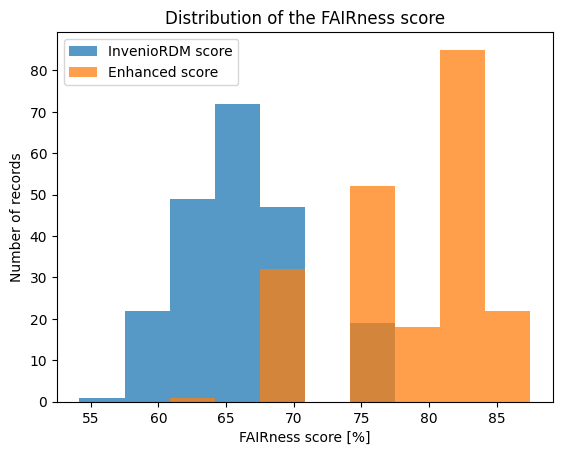

In [13]:
# FAIRness distribution, a juxtaposition between the two types of metadata
differences_df[['InvenioRDM score', 'Enhanced score']].plot.hist(ylabel="Number of records",
                                                                 xlabel="FAIRness score [%]",
                                                                 title="Distribution of the FAIRness score", alpha=0.75)

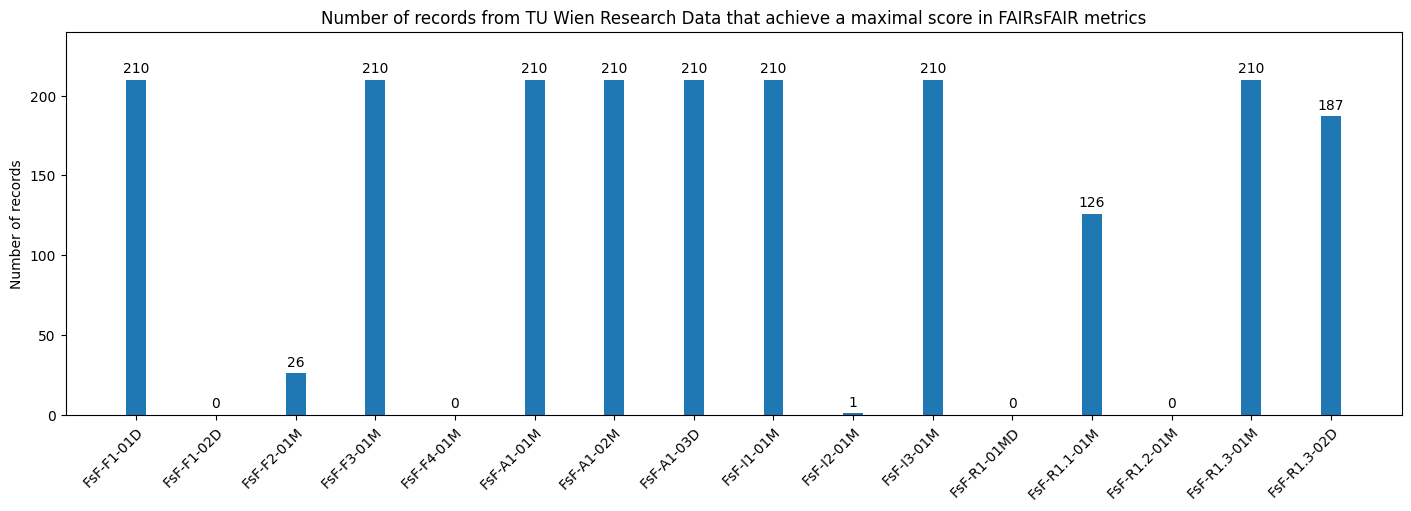

In [19]:
graph_stats_singular(invenio_df, metrics, 'Number of records from TU Wien Research Data that achieve a maximal score in FAIRsFAIR metrics')

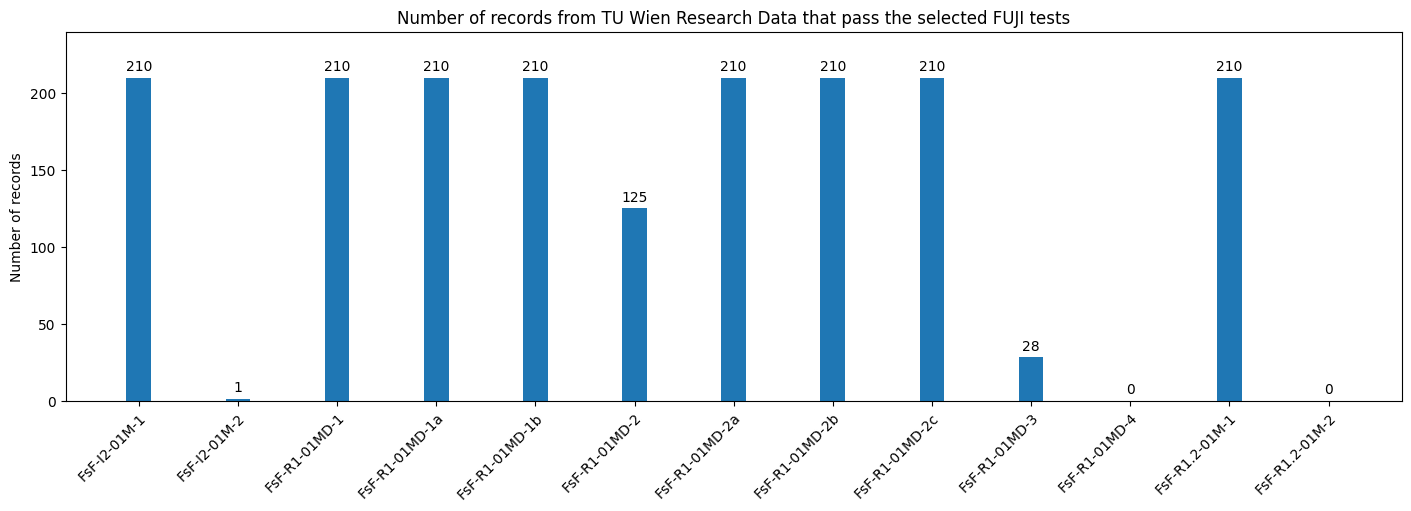

In [21]:
graph_stats_singular(invenio_df, {key: value for key, value in tests.items() if key in selected_tests}, 'Number of records from TU Wien Research Data that pass the selected FUJI tests')

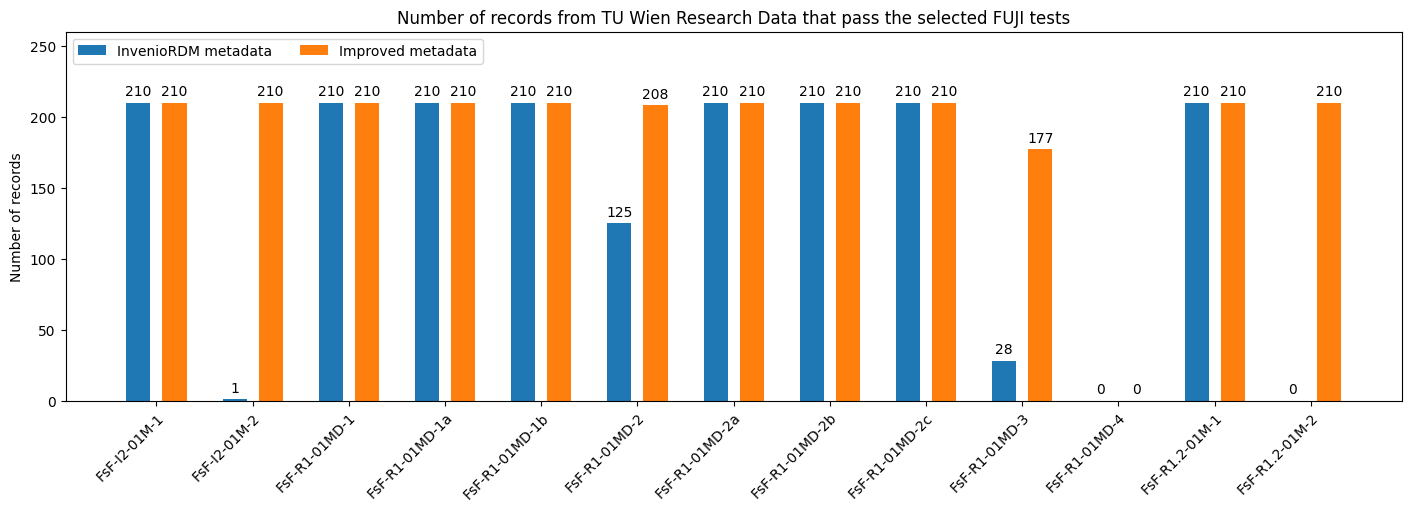

In [20]:
selected_tests = [test for test in tests if 'FsF-I2-01M' in test or 'FsF-R1-01MD' in test or 'FsF-R1.2-01M' in test]
graph_stats_max(invenio_df[selected_tests], enhanced_df[selected_tests], 'InvenioRDM metadata', 'Improved metadata', {key: value for key, value in tests.items() if key in selected_tests}, 'Number of records from TU Wien Research Data that pass the selected FUJI tests')

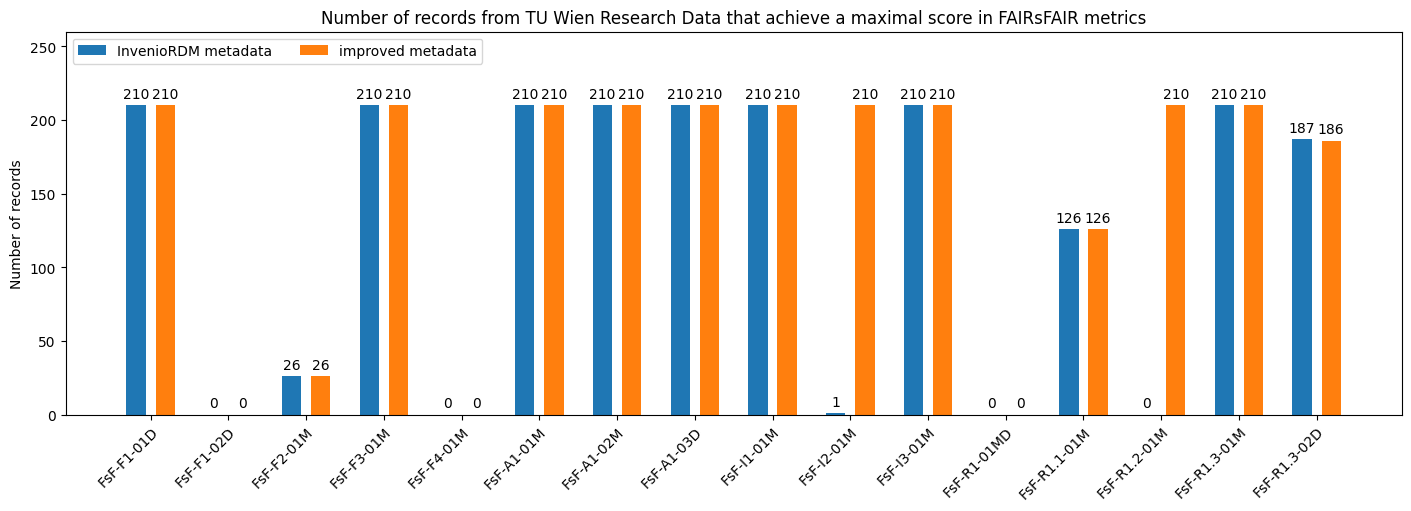

In [17]:
graph_stats_max(invenio_df, enhanced_df, 'InvenioRDM metadata', 'improved metadata', metrics,
                'Number of records from TU Wien Research Data that achieve a maximal score in FAIRsFAIR metrics')

------

# Which metrics have been improved

In [23]:
# Which metrics have been improved
for col in enhanced_df[metrics.keys()].columns:
    summary_enhanced = enhanced_df.describe()
    summary_invenio = invenio_df.describe()

    if summary_enhanced[col]['mean'] > summary_invenio[col]['mean']:
        print(f"---- metric: {col} ----")
        print(f"min achieved values: {summary_enhanced[col]['min']} vs {summary_invenio[col]['min']}")
        print(f"max achieved values: {summary_enhanced[col]['max']} vs {summary_invenio[col]['max']}")
        print(f"mean values: {summary_enhanced[col]['mean']} vs {summary_invenio[col]['mean']}")
        print(f"max possible score: {metrics[col]}")
        print(f"---- --- ----")

---- metric: FsF-I2-01M ----
min achieved values: 1.0 vs 0.0
max achieved values: 1.0 vs 1.0
mean values: 1.0 vs 0.004761904761904762
max possible score: 1
---- --- ----
---- metric: FsF-R1-01MD ----
min achieved values: 1.0 vs 1.0
max achieved values: 3.0 vs 3.0
mean values: 2.8333333333333335 vs 1.7285714285714286
max possible score: 4
---- --- ----
---- metric: FsF-R1.2-01M ----
min achieved values: 2.0 vs 1.0
max achieved values: 2.0 vs 1.0
mean values: 2.0 vs 1.0
max possible score: 2
---- --- ----
